In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [2]:
class DropoutNet(nn.Module):
    def __init__(self, in_size, h1, h2, out_size, p=0):
        super(DropoutNet, self).__init__()
        self.drop = nn.Dropout(p)
        self.hidden1 = nn.Linear(in_size, h1)
        self.hidden2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_size)

    def forward(self, x):
        a1 = nn.SiLU()(self.hidden1(x))
        a1 = self.drop(a1)
        a2 = nn.SiLU()(self.hidden2(a1))
        a2 = self.drop(a2)
        y_hat = self.out(a2)
        return y_hat

In [3]:
# or sequentially
# in_dim = 2
# h1 = 256
# h2 = 256
# out_dim = 2
#
# model = nn.Sequential(
#     nn.Linear(in_dim, h1),
#     nn.SiLU(),
#     nn.Dropout(0.2),
#     nn.Linear(h1, h2),
#     nn.SiLU(),
#     nn.Dropout(0.2),
#     nn.Linear(h2, out_dim)
# )
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#
# model

In [40]:
class Data(Dataset):

    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(
            a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[
                                                                                                                      5:7]).flatten()
        self.a = a

        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)

        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0, 1].numpy(), 'bo', label='y=0')
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1, 1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend()

    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(
            self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

In [41]:
def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]

    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light)

    plt.title("decision region vs True decision boundary")

In [42]:
model_drop = DropoutNet(2, 300, 300, 2, p=0.5)
model_drop.train()
model = DropoutNet(2, 300, 300, 2)

In [43]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

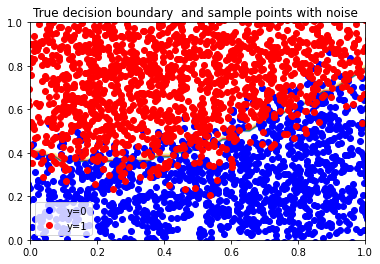

In [44]:
# plot the training data
data_set = Data(noise_std=0.09, N_SAMPLES=3000)
data_set.plot()

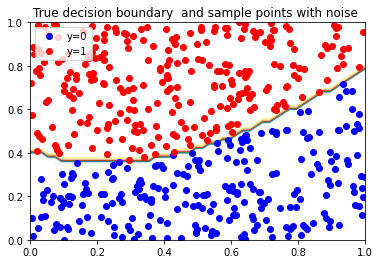

In [45]:
validation_set = Data(N_SAMPLES=500, train=False)
validation_set.plot()

In [46]:
LOSS = {
    'training data no dropout': [],
    'validation data no dropout': [],
    'training data dropout': [],
    'validation data dropout': []
}

In [47]:
epochs = 1000
model_drop.train()

for epoch in range(epochs):
    #all the samples are used for training
    yhat = model(data_set.x)
    yhat_drop = model_drop(data_set.x)
    loss = criterion(yhat, data_set.y)
    loss_drop = criterion(yhat_drop, data_set.y)

    #store the loss for both the training and validation data for both models
    LOSS['training data no dropout'].append(loss.item())
    LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
    LOSS['training data dropout'].append(loss_drop.item())
    model_drop.eval()
    LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
    model_drop.train()

    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()

    print(f"Done with epoch {epoch}")

Done with epoch 0
Done with epoch 1
Done with epoch 2
Done with epoch 3
Done with epoch 4
Done with epoch 5
Done with epoch 6
Done with epoch 7
Done with epoch 8
Done with epoch 9
Done with epoch 10
Done with epoch 11
Done with epoch 12
Done with epoch 13
Done with epoch 14
Done with epoch 15
Done with epoch 16
Done with epoch 17
Done with epoch 18
Done with epoch 19
Done with epoch 20
Done with epoch 21
Done with epoch 22
Done with epoch 23
Done with epoch 24
Done with epoch 25
Done with epoch 26
Done with epoch 27
Done with epoch 28
Done with epoch 29
Done with epoch 30
Done with epoch 31
Done with epoch 32
Done with epoch 33
Done with epoch 34
Done with epoch 35
Done with epoch 36
Done with epoch 37
Done with epoch 38
Done with epoch 39
Done with epoch 40
Done with epoch 41
Done with epoch 42
Done with epoch 43
Done with epoch 44
Done with epoch 45
Done with epoch 46
Done with epoch 47
Done with epoch 48
Done with epoch 49
Done with epoch 50
Done with epoch 51
Done with epoch 52
Don

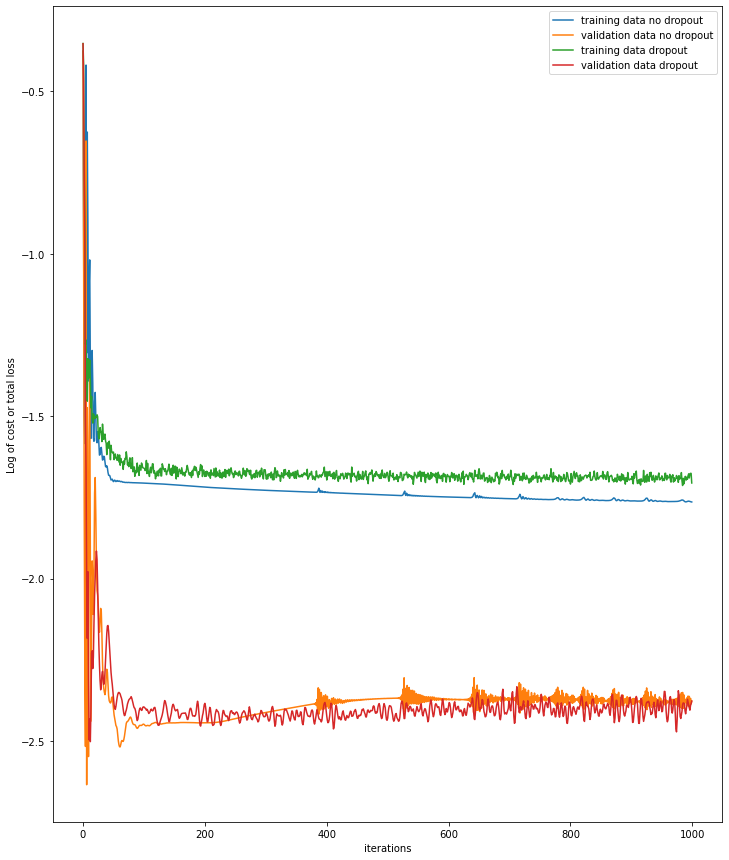

In [48]:
plt.figure(figsize=(12, 15))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

C:\Users\benja\AppData\Local\Temp/ipykernel_51800/2131931494.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, f, cmap=cmap_light)


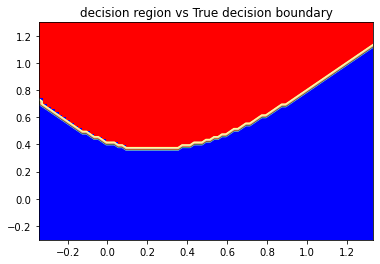

In [49]:
plot_decision_regions_3class(data_set)

C:\Users\benja\AppData\Local\Temp/ipykernel_51800/2131931494.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)


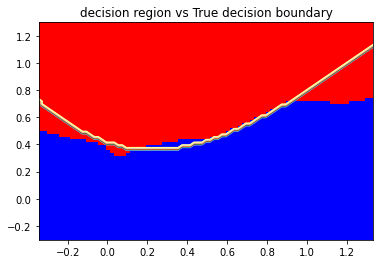

In [50]:
plot_decision_regions_3class(data_set, model)

C:\Users\benja\AppData\Local\Temp/ipykernel_51800/2131931494.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)


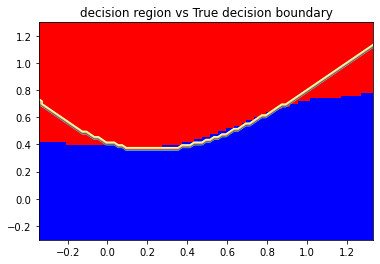

In [51]:
plot_decision_regions_3class(data_set, model_drop)